In [1]:
import torch
from tqdm.auto import tqdm
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import json
import random
random.seed(42)
sns.set_style("darkgrid")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from OutfitTransformer.model.encoder import ItemEncoder
from OutfitTransformer.model.model import OutfitTransformer
from transformers import AutoTokenizer

weights_path = "OutfitTransformer/checkpoints/2_0.923.pth"
outfit_transformer_weights = torch.load(weights_path)


model = OutfitTransformer(embedding_dim=128).to(device)
model.load_state_dict(outfit_transformer_weights['model_state_dict'], strict=False)
model.eval()

with open("data/Re-PolyVore_encoded_with_OutfitTransformer.json", "r", encoding="utf-8") as f:
    outfits_dict = json.load(f)

In [3]:
outfits_at_least_3 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 2:
            outfits_at_least_3.update({key: val})
    else: pass

outfits_at_least_4 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 3:
            outfits_at_least_4.update({key: val})
    else: pass

outfits_at_least_5 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 4:
            outfits_at_least_5.update({key: val})
    else: pass

outfits_at_least_6 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 5:
            outfits_at_least_6.update({key: val})
    else: pass

outfits_at_least_7 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 6:
            outfits_at_least_7.update({key: val})
    else: pass

outfits_at_least_8 = {}
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        if len(val["items"]) > 7:
            outfits_at_least_8.update({key: val})
    else: pass

In [4]:
len(outfits_at_least_3.keys()), len(outfits_at_least_4.keys()), len(outfits_at_least_5.keys()), len(outfits_at_least_6.keys()), len(outfits_at_least_7.keys()), len(outfits_at_least_8.keys())

(13106, 9371, 5305, 2301, 771, 162)

In [5]:
max_set_len = 0
for key, outfit in outfits_dict.items():
    if outfit.get("items") is not None:
        max_set_len = max(max_set_len, len(outfit["items"]))
max_set_len

8

In [6]:
def get_outfit_score(outfit_items, model=model):
    set_mask = torch.zeros(len(outfit_items)).to(device)
    inp = torch.Tensor([elem["embdedding"] for elem in outfit_items]).to(device)
    return model("cp", inp.unsqueeze(0), set_mask.unsqueeze(0).to(device)).item()

In [7]:
all_items = []
for key, val in outfits_dict.items():
    if val.get("items") is not None:
        all_items.extend(val["items"])
    else: pass
len(all_items)

63359

In [8]:
def get_top_k_greedy_singlestep_score(outfit, k, model=model, items=all_items):
    items_to_complete = random.sample(outfit['items'], len(outfit['items']) - k)

    scores_and_items = []
    for item_ind, item in enumerate(tqdm(items, leave=False)):
        score = get_outfit_score(items_to_complete + [item])
        scores_and_items.append((score, item_ind))

    scores_and_items = sorted(scores_and_items)[::-1]
    best_items_ind = [el[1] for el in scores_and_items[:k]]
    best_items = [items[i] for i in best_items_ind]

    final_outfit = items_to_complete + best_items
    final_score = get_outfit_score(final_outfit)
    return final_score

def get_top_k_greedy_multistep_score(outfit, k, model=model, items=all_items):
    items_to_complete = random.sample(outfit['items'], len(outfit['items']) - k)

    best_items_ind = []
    best_items = []

    while len(best_items_ind) < k:
        
        scores_and_items = []
        for item_ind, item in enumerate(tqdm(items, leave=False)):
            if item_ind not in best_items_ind:
                score = get_outfit_score(items_to_complete + [item])
                scores_and_items.append((score, item_ind))
        
        scores_and_items = sorted(scores_and_items)[::-1]
        best_items_ind.append(scores_and_items[0][1])
        best_items.append(items[scores_and_items[0][1]])
        items_to_complete.append(items[scores_and_items[0][1]])

    final_outfit = items_to_complete + best_items
    final_score = get_outfit_score(final_outfit)
    return final_score

def get_top_k_greedy_single_and_multistep_score(outfit, k, model=model, items=all_items):
    items_to_complete = random.sample(outfit['items'], len(outfit['items']) - k)

    best_items_ind = []
    best_items = []

    while len(best_items_ind) < k:
        
        scores_and_items = []
        for item_ind, item in enumerate(tqdm(items, leave=False)):
            if item_ind not in best_items_ind:
                score = get_outfit_score(items_to_complete + [item])
                scores_and_items.append((score, item_ind))
        
        scores_and_items = sorted(scores_and_items)[::-1]
        
        if len(best_items_ind) == 0:
            best_items_ind_single = [el[1] for el in scores_and_items[:k]]
            best_items_single = [items[i] for i in best_items_ind_single]
            final_outfit_single  = items_to_complete + best_items_single
            final_score_single  = get_outfit_score(final_outfit_single)
            
        best_items_ind.append(scores_and_items[0][1])
        best_items.append(items[scores_and_items[0][1]])
        items_to_complete.append(items[scores_and_items[0][1]])

    final_outfit = items_to_complete + best_items
    final_score = get_outfit_score(final_outfit)
    return final_score_single, final_score

In [327]:
# results_min8_k2 = {}

In [9]:
for key, outfit in tqdm(list(outfits_at_least_8.items())):
    if results_min8_k2.get(key) is None:
        results_min8_k2.update({key: {"original": get_outfit_score(outfit['items'])}})

    if results_min8_k2[key].get("greedy_singlestep") is None:
        results_min8_k2[key].update({"greedy_singlestep": get_top_k_greedy_singlestep_score(outfit, k=2)})

In [10]:
for key, outfit in tqdm(list(outfits_at_least_8.items())):
    if results_min8_k2.get(key) is None:
        results_min8_k2.update({key: {"original": get_outfit_score(outfit['items'])}})

    if results_min8_k2[key].get("greedy_multistep") is None:
        results_min8_k2[key].update({"greedy_multistep": get_top_k_greedy_multistep_score(outfit, k=2)}) 

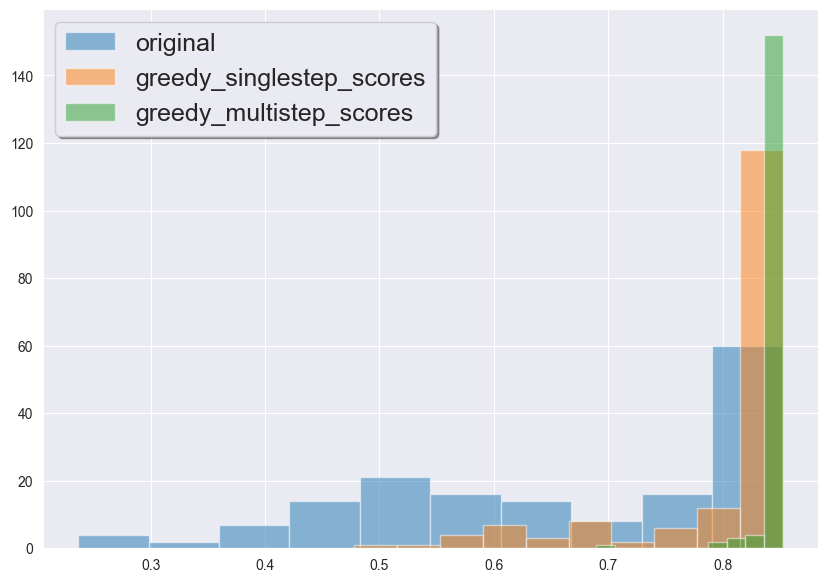

In [336]:
original_scores = []
greedy_singlestep_scores = []
greedy_multistep_scores = []

for key, res_dict in results_min8_k2.items():
    original_scores.append(res_dict["original"])
    greedy_singlestep_scores.append(res_dict["greedy_singlestep"])
    greedy_multistep_scores.append(res_dict["greedy_multistep"])

original_scores, greedy_singlestep_scores, greedy_multistep_scores = \
    np.array(original_scores), np.array(greedy_singlestep_scores), np.array(greedy_multistep_scores)


plt.figure(figsize=(10, 7))

plt.hist(original_scores, bins=10, alpha=0.5, label="original")
plt.hist(greedy_singlestep_scores, bins=10, alpha=0.5, label="greedy_singlestep_scores")
plt.hist(greedy_multistep_scores, bins=10, alpha=0.5, label="greedy_multistep_scores")


plt.legend(fontsize=18, shadow=True)
plt.show()

In [331]:
# with open("data/Re-PolyVore_greedy_results_min8_k2.json", "w", encoding="utf-8") as f:
#         json.dump(results_min8_k2, f, indent=4)

### k=2, min 5 elements per outfit

In [9]:
# outfits_at_least_5_subset100 = {key: elem for key, elem in list(outfits_at_least_5.items())[:100]}
# results_min5_k2_subset100 = {}

for key, outfit in tqdm(list(outfits_at_least_5_subset100.items())):
    if results_min5_k2_subset100.get(key) is None:
        results_min5_k2_subset100.update({key: {"original": get_outfit_score(outfit['items'])}})

    if results_min5_k2_subset100[key].get("greedy_singlestep") is None and results_min5_k2_subset100[key].get("greedy_multistep") is None:
        single_score, multi_score = get_top_k_greedy_single_and_multistep_score(outfit, k=2)
        results_min5_k2_subset100[key].update({"greedy_singlestep": single_score,
                                               "greedy_multistep": multi_score})

    if results_min5_k2_subset100[key].get("greedy_singlestep") is None:
         results_min5_k2_subset100[key].update({"greedy_singlestep": get_top_k_greedy_singlestep_score(outfit, k=2)})

    if results_min5_k2_subset100[key].get("greedy_multistep") is None:
         results_min5_k2_subset100[key].update({"greedy_multistep": get_top_k_greedy_multistep_score(outfit, k=2)}) 
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

  0%|          | 0/63359 [00:00<?, ?it/s]

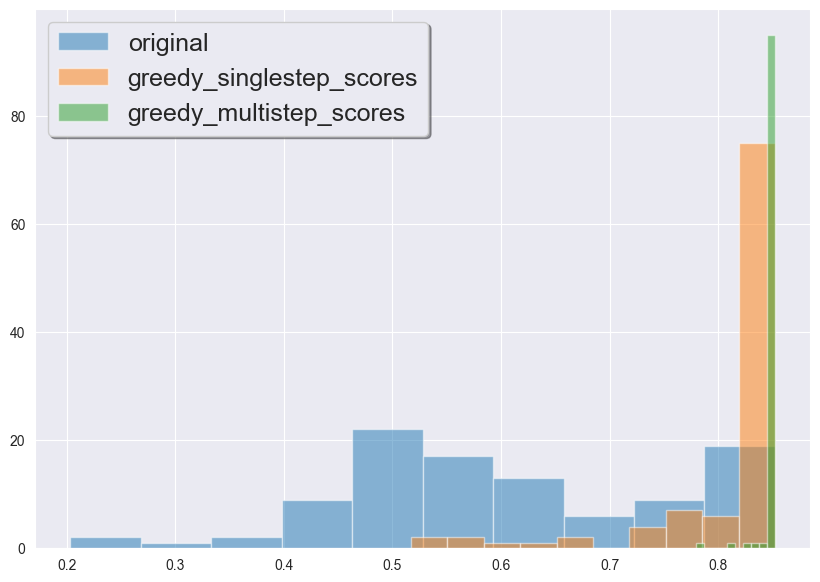

In [10]:
original_scores = []
greedy_singlestep_scores = []
greedy_multistep_scores = []

for key, res_dict in results_min5_k2_subset100.items():
    original_scores.append(res_dict["original"])
    greedy_singlestep_scores.append(res_dict["greedy_singlestep"])
    greedy_multistep_scores.append(res_dict["greedy_multistep"])

original_scores, greedy_singlestep_scores, greedy_multistep_scores = \
    np.array(original_scores), np.array(greedy_singlestep_scores), np.array(greedy_multistep_scores)


plt.figure(figsize=(10, 7))

plt.hist(original_scores, bins=10, alpha=0.5, label="original")
plt.hist(greedy_singlestep_scores, bins=10, alpha=0.5, label="greedy_singlestep_scores")
plt.hist(greedy_multistep_scores, bins=10, alpha=0.5, label="greedy_multistep_scores")


plt.legend(fontsize=18, shadow=True)
plt.show()

In [11]:
with open("data/Re-PolyVore_greedy_results_min5_k2_subset100.json", "w", encoding="utf-8") as f:
        json.dump(results_min5_k2_subset100, f, indent=4)